# KELOMPOK 04 PREDIKSI TUMOR OTAK DENGAN GAMBAR MRI (X-RAY) MENGGUNAKAN CNN
---
ANGGOTA KELOMPOK
* MUHAMMAD KAISAR FIRDAUS 121450135
* ADISTY SYAWALDA ARIYANTO 121450136
* ANDINI NUR IZZATI 121450147
* SAIFUL HARIS MUHAMMAD 121450115
* EVAN APRIANTO 121450024
* SYAKIRA TSANIA MUTHMAINNAH 121450110
---

###  dataset yang digunakan : [LINK](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

---

# Color

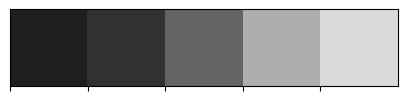

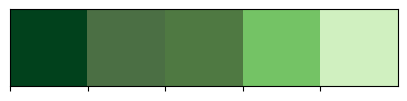

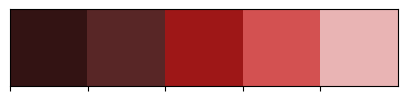

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


bagian ini adalah membaca dataset dari drive dan mengacak kembali namun sesuai dengan urutan antara gambar dan label yang tertera antara train dataset dan test dataset

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm # Make sure to import tqdm

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150

# Correct folder path for training data
training_folder_path = '/content/drive/MyDrive/Tubes DL/Training'
testing_folder_path = '/content/drive/MyDrive/Tubes DL/Testing'

# Loop through each label and its corresponding folder within the training directory
for label in labels:
    label_folder_path = os.path.join(training_folder_path, label)  # Create path to label folder
    for filename in tqdm(os.listdir(label_folder_path)):  # Iterate over files in label folder
        # Construct the full image path
        img_path = os.path.join(label_folder_path, filename)
        # Read and process the image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)
        else:
            print(f"Could not read image: {img_path}")

# Loop through each label and its corresponding folder within the testing directory
for label in labels:
    label_folder_path = os.path.join(testing_folder_path, label)  # Create path to label folder
    for filename in tqdm(os.listdir(label_folder_path)):  # Iterate over files in label folder
        # Construct the full image path
        img_path = os.path.join(label_folder_path, filename)
        # Read and process the image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)
        else:
            print(f"Could not read image: {img_path}")


X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:22<00:00,  3.28it/s]


bagian ini menampilkan contoh 1 gambar dari masing" label

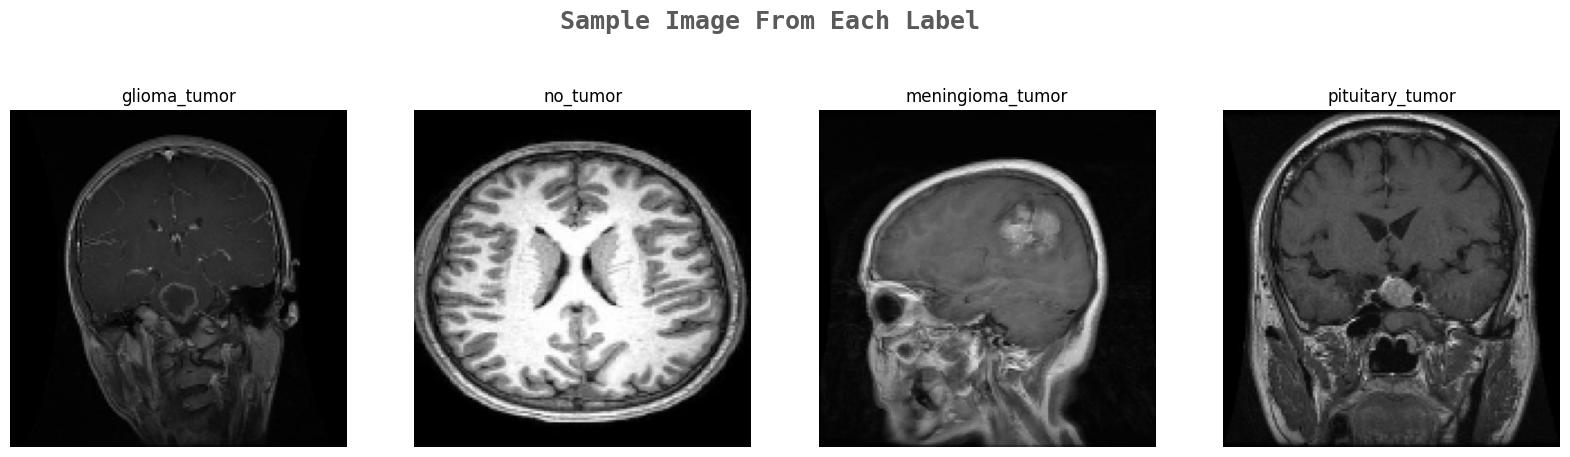

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

bagian ini membuat ulang data train dari data yang sudah di acak dengan pengulangan sebanyak 101 kali

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

dimensi data dimana terdapat 3307 gambar dengan ukuran 150 x 150 pixel 3 channel warna RGB

In [ ]:
X_train.shape

(3307, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

membuat test dataset dari membagi train dataset menjadi test dataset dan set pengujian dengan rasio yang di tentukan sebesat 10% dari total data awal.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [ ]:
model = effnet.output # mengambil output dari effecientnetb0 sebagai input
model = tf.keras.layers.GlobalAveragePooling2D()(model) # avarage pooling untuk reduksi data untuk mencegah overfitting
model = tf.keras.layers.Dropout(rate=0.5)(model) # menghapus 50% neuron secara acak selama pealtihan
model = tf.keras.layers.Dense(4,activation='softmax')(model) # ada 4 ouput (kelas) dan aktifasi softmax untuk membuah probabilitas tiap kelas
model = tf.keras.models.Model(inputs=effnet.input, outputs = model) # menggabungkan model berarti keseluruhan model akan
                                                            # menerima input gambar dan meneruskan data melalui lapisan EfficientNetB0, diikuti oleh Global Average Pooling, Dropout, dan akhirnya lapisan dense untuk klasifikasi.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

* menggunakan fungsi loss untuk menghitung perbedaan probabilitas antar kelas dimana target label disandingkan dalam format one-hot encoding

* optimizer adam mempunyai efisiensi pada learning rate selama pelatihan dengan meng-update bobot model

* dan menampilkan akurasi untuk prediksi model dengan membandingkan antara kelas prediksi dengan kelas target

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

* call back adalah teknik untuk meminimalkan bug yang ada, dengan menyimpan akurasi yang meningkat setiap epoch berjalan.
* dengan teknik ini model akan disimpan setiap mengalami peniingkatan minimal 0.001 dan learning rate akan dikurangi jika ada 2 epoch yang tidak mengalami peningkatan.
dengan faktor pengurangan 0.3

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

tensorboard = TensorBoard(log_dir = 'logs')
# Changing the file extension from 'h5' to 'keras' to match the expected format
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

ubah setting runtime dari CPU ke GPU (T4) untuk mempercepat running code

melatih effecientnetb0 dengan 12x epoch, kemudian mengevaluasi peforma pada data validasi setiap epoch, dan mengoptimalkan parameter dengan bantuan callback.

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7161 - loss: 0.6944
Epoch 1: val_accuracy improved from -inf to 0.74161, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 147s 809ms/step - accuracy: 0.7174 - loss: 0.6918 - val_accuracy: 0.7416 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 2/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9271 - loss: 0.2278
Epoch 2: val_accuracy improved from 0.74161 to 0.85235, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.9272 - loss: 0.2275 - val_accuracy: 0.8523 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 3/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9643 - loss: 0.1090
Epoch 3: val_accuracy improved from 0.85235 to 0.92282, saving model to effnet.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9643 - loss: 0.1090 - val_accuracy: 0.9228 - val_loss: 0.3013 - learning_rate: 0.0010
Epoch 4/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.97

visualisasi performa model selama pelatihan dengan menampilkan grafik antara akurasi dan loss pada data latih serta data validasi

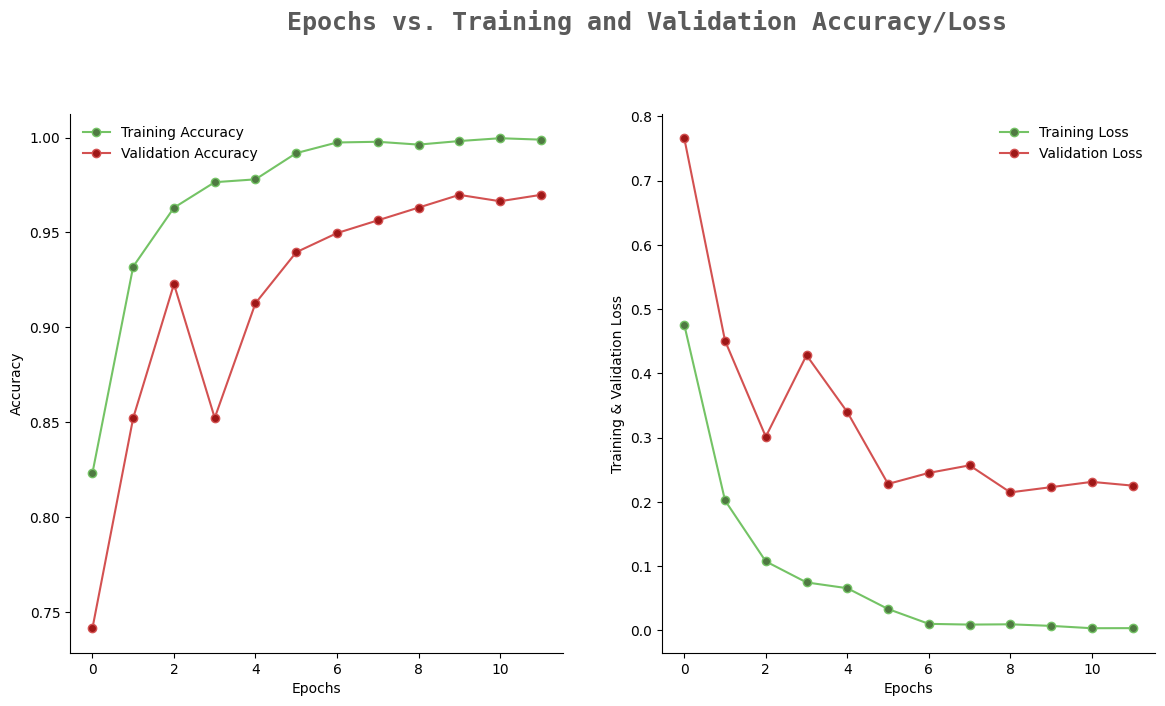

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

membuat prediksi pada data uhi dan mengformat hasil prediksi sert label sebenearnya.

dimana nilai prediksi awalnya berbentuk array yang berisi probabilitas setiap kelas. dan diambil nilai probabilitas yang paling besar.





In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 696ms/step


---

# Evaluation

* classification_report dari sklearn memberikan ringkasan metrik evaluasi berdasarkan prediksi dan label sebenarnya.

Metrik yang ditampilkan:
* Precision: Proporsi prediksi yang benar untuk setiap kelas dibandingkan total
* prediksi untuk kelas tersebut.
* Recall: Proporsi prediksi yang benar untuk setiap kelas dibandingkan total data sebenarnya di kelas tersebut.
* F1-Score: Rata-rata harmonik antara precision dan recall.
Support: Jumlah sampel di setiap kelas.

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        96
           1       0.98      0.98      0.98        48
           2       0.96      0.99      0.97        89
           3       1.00      0.99      0.99        98

    accuracy                           0.98       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.98      0.98      0.98       331



membuat heatmap dari matriks confolusion yang menampilkan tentang jumlah prediksi benar (diagonal) dan salah (di luar diagonal) dengan baris sebagai kelas dan kolom sebagai prediksi model.

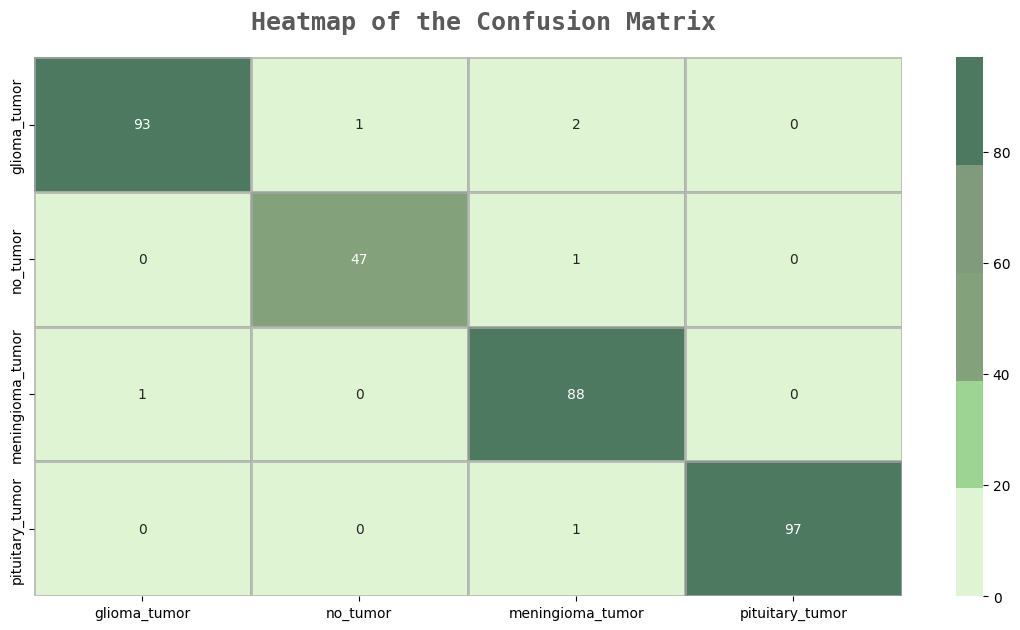

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

kode ini adalah fungsi untuk meng-upload gambar baru yang ingin di prediksi dengan mengubah gambar tersebut menjadi inputan yang sesuai dengan model yang dipakai.

dimana hasil akhir berupa angka 0-3 dimana mewakili setiap kelas yang sudah di prediksi sebelumnya

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

untuk upload gambar

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

dan untuk melihat hasil prediksi model dari gambar yang diupload


In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

# **Kesimpulan:**

1. **Transfer Learning dan Penggunaan EfficientNetB0:**
   - Anda menggunakan **Transfer Learning** dengan model **EfficientNetB0** yang sudah dilatih pada dataset **ImageNet**. Hal ini bertujuan untuk memanfaatkan fitur-fitur yang sudah dipelajari oleh model sebelumnya dan mengaplikasikannya pada tugas klasifikasi gambar tumor otak, mengurangi waktu pelatihan dan meningkatkan akurasi.
   - Dengan menggunakan **EfficientNetB0** sebagai model dasar (pre-trained model), Anda hanya melatih beberapa layer terakhir model untuk menyesuaikan dengan tugas klasifikasi spesifik yang Anda kerjakan.

2. **Praproses Data dan Visualisasi:**
   - Anda mempersiapkan data citra dengan memuat gambar, mengubah ukuran gambar menjadi **150x150** piksel, dan mengonversinya menjadi format yang kompatibel dengan model menggunakan **OpenCV** dan **NumPy**.
   - Data latih dan data uji dibagi menggunakan **train_test_split** dan divisualisasikan dengan **matplotlib** dan **seaborn** untuk menampilkan akurasi serta loss pada setiap epoch pelatihan, serta confusion matrix untuk menilai performa model pada data uji.

3. **Penggunaan Callback:**
   - Anda menggunakan berbagai **callback functions** seperti **TensorBoard**, **ModelCheckpoint**, dan **ReduceLROnPlateau** untuk memonitor dan mengoptimalkan pelatihan model.
     - **TensorBoard** digunakan untuk visualisasi pelatihan.
     - **ModelCheckpoint** menyimpan model terbaik berdasarkan **val_accuracy**.
     - **ReduceLROnPlateau** menurunkan learning rate jika tidak ada peningkatan dalam validasi akurasi.

4. **Evaluasi Model:**
   - Setelah pelatihan, Anda mengevaluasi model menggunakan **classification_report** dan **confusion matrix** untuk menilai kinerja model, serta menggunakan **`argmax`** untuk mengonversi hasil prediksi model dari probabilitas menjadi label kelas yang diprediksi.
   - Hasil dari model menunjukkan performa yang cukup baik dalam mengklasifikasikan gambar ke dalam kategori tumor otak, dengan akurasi yang baik pada data uji.

5. **Prediksi Gambar Baru:**
   - Anda membuat fungsi **`img_pred`** untuk memprediksi label gambar baru yang diunggah oleh pengguna. Fungsi ini memuat gambar, mempersiapkannya, dan memberikan prediksi berdasarkan model yang telah dilatih.

Secara keseluruhan, Anda telah berhasil mengimplementasikan model **EfficientNetB0** dengan **Transfer Learning** untuk klasifikasi gambar tumor otak, melakukan evaluasi model, dan menambahkan kemampuan untuk memprediksi gambar baru yang diunggah oleh pengguna.

# Test

## Menyimpan model

In [ ]:
# Menyimpan model ke file .keras atau .h5
model.save('model_tumor_prediction.keras')  # Anda bisa menggunakan format .h5 jika ingin

## Mengunduh Model ke Komputer

In [ ]:
from google.colab import files
files.download('model_tumor_prediction.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Import Model yang sudah disimpan

In [ ]:
from tensorflow.keras.models import load_model

# Memuat model yang telah disimpan
model = load_model('model_tumor_prediction.keras')


## Menyimpan Model Ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/Tubes DL/model_tumor_prediction.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Menimport model yang sudah di simpan di google drive

In [ ]:
model = load_model('/content/drive/MyDrive/Tubes DL/model_tumor_prediction.keras')


## prediksi gambar baru dengan model yang sudah di simpan

In [ ]:
# Fungsi untuk memprediksi gambar baru
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')


## upload dan prediksi gambar baru

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')